# LSTM - Stateful

Example script showing how to use a stateful LSTM model and how its stateless counterpart performs.

More documentation about the Keras LSTM model can be found at https://keras.io/layers/recurrent/#lstm

The models are trained on an input/output pair, where the input is a generated uniformly distributed
random sequence of length = "input_len", and the output is a moving average of the input with 
window length = "tsteps". Both "input_len" and "tsteps" are defined in the "editable parameters" section.

A larger "tsteps" value means that the LSTM will need more memory to figure out the input-output relationship.
This memory length is controlled by the "lahead" variable (more details below).

The rest of the parameters are:
- input_len: the length of the generated input sequence
- lahead: the input sequence length that the LSTM
  is trained on for each output point
- batch_size, epochs: same parameters as in the model.fit(...) function

When lahead > 1, the model input is preprocessed to a "rolling window view"
of the data, with the window length = "lahead".
This is similar to sklearn's "view_as_windows"
with "window_shape" being a single number
Ref: http://scikit-image.org/docs/0.10.x/api/skimage.util.html#view-as-windows

When lahead < tsteps, only the stateful LSTM converges because its
statefulness allows it to see beyond the capability that lahead
gave it to fit the n-point average. The stateless LSTM does not have
this capability, and hence is limited by its "lahead" parameter,
which is not sufficient to see the n-point average.

When lahead >= tsteps, both the stateful and stateless LSTM converge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
# ----------------------------------------------------------
# EDITABLE PARAMETERS
# Read the documentation in the script head for more details
# ----------------------------------------------------------

# length of input
input_len = 1000

# The window length of the moving average used to generate
# the output from the input in the input/output pair used
# to train the LSTM
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 2

# The input sequence length that the LSTM is trained on for each output point
lahead = 1

# training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 10

In [3]:
# ------------
# MAIN PROGRAM
# ------------

print("*" * 33)
if lahead >= tsteps:
    print("STATELESS LSTM WILL ALSO CONVERGE")
else:
    print("STATELESS LSTM WILL NOT CONVERGE")
print("*" * 33)

*********************************
STATELESS LSTM WILL NOT CONVERGE
*********************************


In [4]:
np.random.seed(1986)

print('Generating Data...')

Generating Data...


In [5]:
def gen_uniform_amp(amp=1, xn=10000):
    """Generates uniform random data between
    -amp and +amp
    and of length xn

    Arguments:
        amp: maximum/minimum range of uniform data
        xn: length of series
    """
    data_input = np.random.uniform(-1 * amp, +1 * amp, xn)
    data_input = pd.DataFrame(data_input)
    return data_input

In [6]:
# Since the output is a moving average of the input,
# the first few points of output will be NaN
# and will be dropped from the generated data
# before training the LSTM.
# Also, when lahead > 1,
# the preprocessing step later of "rolling window view"
# will also cause some points to be lost.
# For aesthetic reasons,
# in order to maintain generated data length = input_len after pre-processing,
# add a few points to account for the values that will be lost.
to_drop = max(tsteps - 1, lahead - 1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)

In [7]:
# set the target to be a N-point average of the input
expected_output = data_input.rolling(window=tsteps, center=False).mean()

# when lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)

In [8]:
# drop the nan
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

print('Input shape:', data_input.shape)
print('Output shape:', expected_output.shape)
print('Input head: ')
print(data_input.head())
print('Output head: ')
print(expected_output.head())
print('Input tail: ')
print(data_input.tail())
print('Output tail: ')
print(expected_output.tail())

Input shape: (1000, 1)
Output shape: (1000, 1)
Input head: 
          0
1 -0.084532
2  0.021696
3  0.079500
4  0.008981
5  0.040544
Output head: 
          0
1 -0.035379
2 -0.031418
3  0.050598
4  0.044240
5  0.024763
Input tail: 
             0
996   0.010251
997  -0.027833
998   0.003984
999   0.028471
1000 -0.057877
Output tail: 
             0
996   0.025187
997  -0.008791
998  -0.011925
999   0.016227
1000 -0.014703


Plotting input and expected output


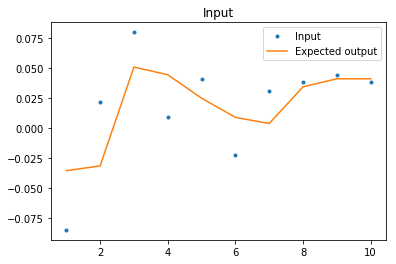

In [9]:
print('Plotting input and expected output')
plt.plot(data_input[0][:10], '.')
plt.plot(expected_output[0][:10], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
plt.show()

In [10]:
def create_model(stateful):
    model = Sequential()
    model.add(LSTM(20,
              input_shape=(lahead, 1),
              batch_size=batch_size,
              stateful=stateful))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [11]:
print('Creating Stateful Model...')
model_stateful = create_model(stateful=True)
model_stateful.summary()

Creating Stateful Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 20)                   1760      
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [12]:
# split train/test data
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    # tweak to match with batch_size
    to_train -= to_train % batch_size

    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]

    # tweak to match with batch_size
    to_drop = x.shape[0] % batch_size
    if to_drop > 0:
        x_test = x_test[:-1 * to_drop]
        y_test = y_test[:-1 * to_drop]

    # some reshaping
    reshape_3 = lambda x: x.values.reshape((x.shape[0], x.shape[1], 1))
    x_train = reshape_3(x_train)
    x_test = reshape_3(x_test)

    reshape_2 = lambda x: x.values.reshape((x.shape[0], 1))
    y_train = reshape_2(y_train)
    y_test = reshape_2(y_test)

    return (x_train, y_train), (x_test, y_test)

In [13]:
(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (800, 1, 1)
y_train.shape:  (800, 1)
x_test.shape:  (200, 1, 1)
y_test.shape:  (200, 1)


In [14]:
print('Training')
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    model_stateful.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(x_test, y_test),
                       shuffle=False)
    model_stateful.reset_states()

Training
Epoch 1 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 4s 5ms/step - loss: 5.9774e-04 - val_loss: 5.0830e-04
Epoch 2 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 3.0102e-04 - val_loss: 2.6935e-04
Epoch 3 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 2.5034e-04 - val_loss: 2.1728e-04
Epoch 4 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 2.4437e-04 - val_loss: 2.0971e-04
Epoch 5 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 2.4829e-04 - val_loss: 2.0522e-04
Epoch 6 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 4ms/step - loss: 2.5227e-04 - val_loss: 2.0671

In [15]:
print('Predicting')
predicted_stateful = model_stateful.predict(x_test, batch_size=batch_size)

Predicting


In [16]:
print('Creating Stateless Model...')
model_stateless = create_model(stateful=False)

Creating Stateless Model...


In [17]:
print('Training')
model_stateless.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

Training
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5858e-04 - val_loss: 0.0010
Epoch 3/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5562e-04 - val_loss: 0.0010
Epoch 4/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5408e-04 - val_loss: 9.9550e-04
Epoch 5/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5306e-04 - val_loss: 9.8786e-04
Epoch 6/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5232e-04 - val_loss: 9.8184e-04
Epoch 7/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5169e-04 - val_loss: 9.7659e-04
Epoch 8/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5112e-04 - val_loss: 9.7191e-04
Epoch 9/10
800/800 [==============================] - 3s 4ms/step - loss: 8.5063e-04 - val_loss: 

In [18]:
print('Predicting')
predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)

Predicting


Plotting Results


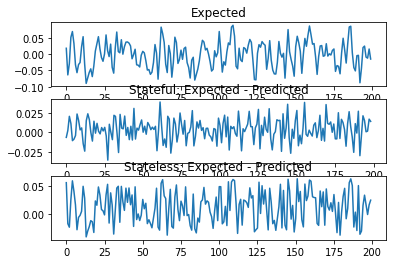

In [19]:
# ----------------------------

print('Plotting Results')
plt.subplot(3, 1, 1)
plt.plot(y_test)
plt.title('Expected')
plt.subplot(3, 1, 2)
# drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist
plt.plot((y_test - predicted_stateful).flatten()[tsteps - 1:])
plt.title('Stateful: Expected - Predicted')
plt.subplot(3, 1, 3)
plt.plot((y_test - predicted_stateless).flatten())
plt.title('Stateless: Expected - Predicted')
plt.show()